In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import classification_report, f1_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.pipeline import Pipeline

import matplotlib.style as style
style.use("seaborn-darkgrid")

# dataset basic info

### About pima diabetes dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

#### Content:
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### loading dataset

In [2]:
df=pd.read_csv('PIMA_diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Basic info 

In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


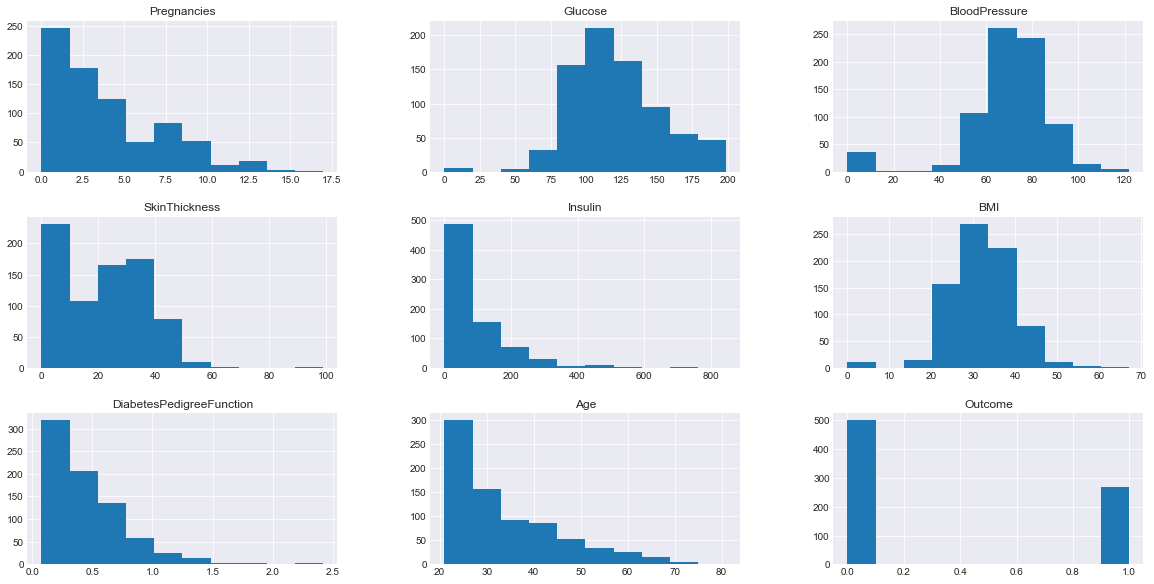

In [5]:
df.hist(figsize=(20,10))
plt.show()

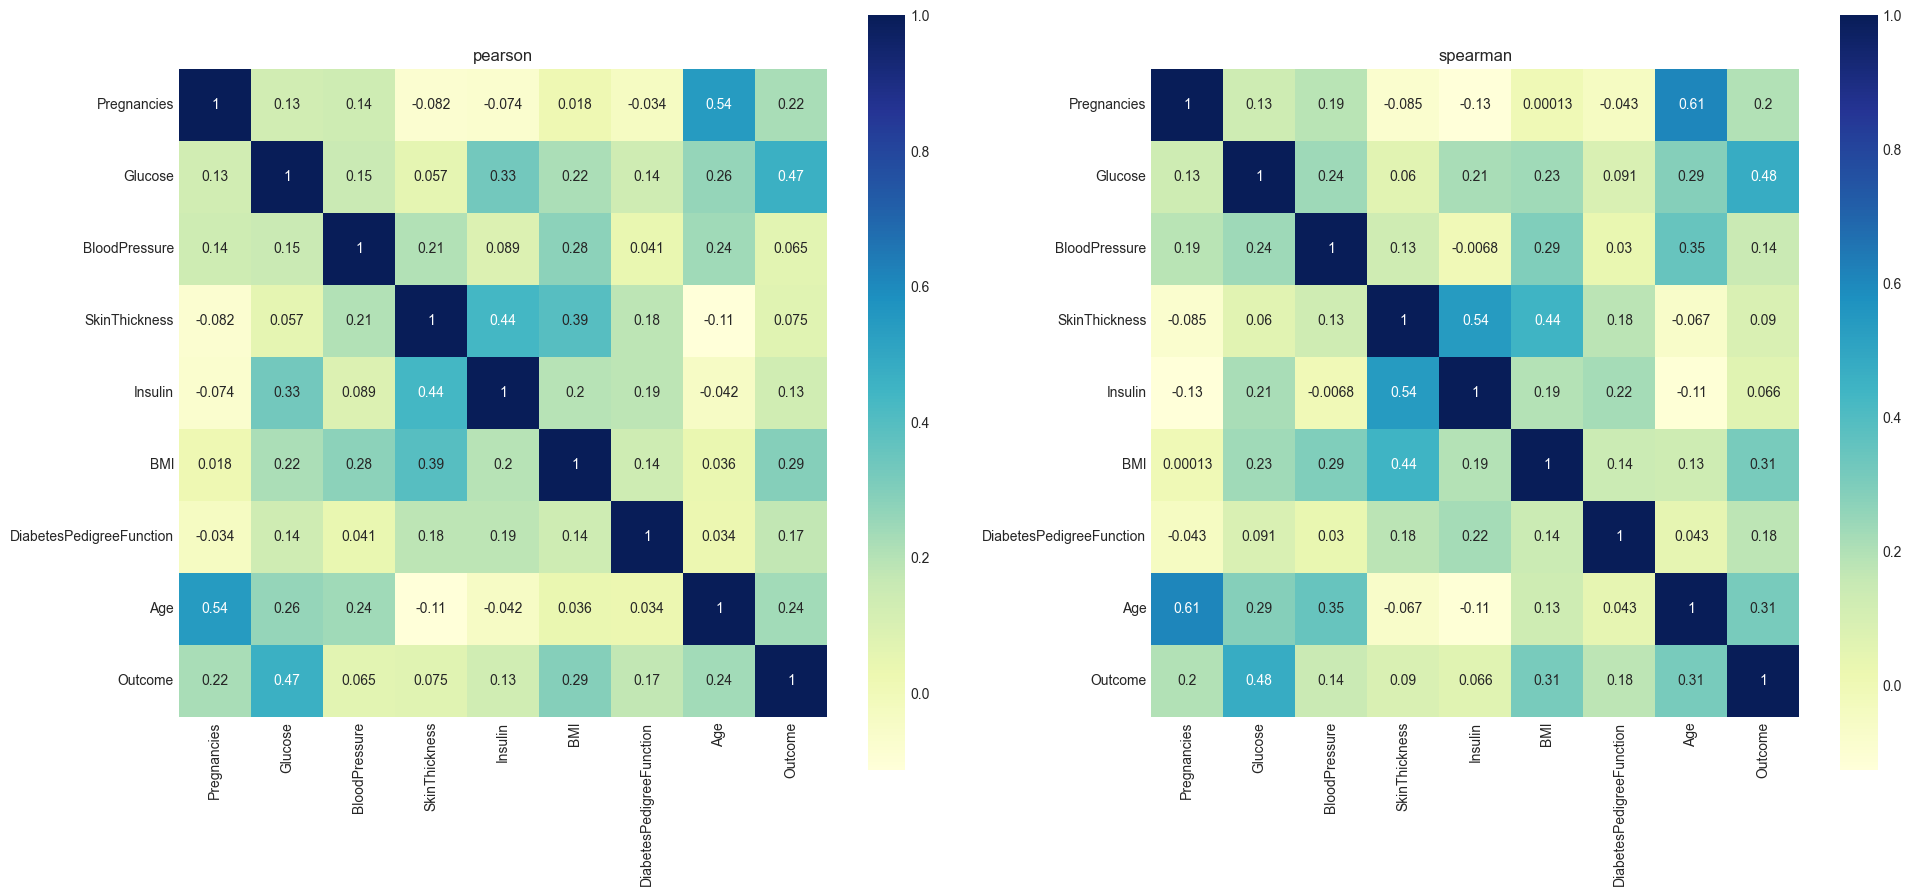

In [6]:
fig , ax= plt.subplots(1,2, figsize=(23,10), dpi=100)

pearson=df.corr()
ax[0].set_title('pearson')
sns.heatmap(pearson, cmap='YlGnBu', square=True, annot=True, ax=ax[0])

spearman=df.corr(method='spearman')
ax[1].set_title('spearman')
sns.heatmap(spearman, cmap='YlGnBu', square=True, annot=True, ax=ax[1])

plt.show()

##### Separating features and label

In [7]:
X=df.drop('Outcome',axis=1)
y=df.Outcome
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [8]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

##### train test split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=5)

# func

In [11]:
def score(model, xTrain, yTrain, xTest, yTest):
    
    model.fit(xTrain,yTrain)
    print(f'train accuracy:{ model.score(xTrain,yTrain) :.2f}')
    
    yPred=model.predict(xTest)

    print('\nclassification report:\n',classification_report(yTest, yPred))
    
    print('\nconfusion matrix:')
    sns.heatmap( confusion_matrix(yTest, yPred ), annot=True, cmap='OrRd')
    plt.xlabel('pred')
    plt.ylabel('actual')

### 1 LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,classification_report,precision_score,recall_score,confusion_matrix

model=LogisticRegression(max_iter=100000, class_weight='balanced') # use solver like 'sag' or 'sagg'

score(model, xTrain, yTrain, xTest, yTest)

### 2 DECISION TREE

from sklearn.tree import DecisionTreeClassifier as DTC

model=DTC(max_depth=5,  criterion='entropy')   #min_impurity_decrease=0.1) #,

score(model, xTrain, yTrain, xTest, yTest)

### 3 RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier as RFC

model=RFC(n_estimators=300,  max_samples=.5, n_jobs=-1, class_weight='balanced')   

score(model, xTrain, yTrain, xTest, yTest)

### 4 GRADBOOST

from sklearn.ensemble import GradientBoostingClassifier as GBC

model=GBC(n_estimators=500, learning_rate=.1, max_depth=7, max_features=3)

score(model, xTrain, yTrain, xTest, yTest)

### 5 XGB

from xgboost import XGBClassifier

model=XGBClassifier(n_jobs=-1)   #n_estimators=10000, learning_rate=.00001, 

score(model, xTrain, yTrain, xTest, yTest)

### 6 ADABOOST CLASSIFIER

from sklearn.ensemble import AdaBoostClassifier as ABC

''' DT as base'''
model=ABC(base_estimator=DTC(max_depth=10), n_estimators=100, learning_rate=0.1)

score(model, xTrain, yTrain, xTest, yTest)

''' RF as base'''
RF_=RFC(n_estimators=100, n_jobs=-1, max_depth=5, min_samples_leaf=20)

model=ABC(base_estimator=RF_, n_estimators=100, learning_rate=0.1)

score(model, xTrain, yTrain, xTest, yTest)

### 7 SVM

from sklearn.svm import SVC

model = SVC(kernel='poly')

score(model, xTrain, yTrain, xTest, yTest)

### 8 KNC

from sklearn.neighbors import KNeighborsClassifier as KNC

model=KNC(n_neighbors=5)

score(model, xTrain, yTrain, xTest, yTest)

### 9 RNC

from sklearn.neighbors import RadiusNeighborsClassifier as RNC

model=RNC(radius=10000)

score(model, xTrain, yTrain, xTest, yTest)

# Pipeline

pipelines=[]
f1={}

models={'gnb':GaussianNB()}

for name,model in models.items():
    
    # making pipeline for each model
    pipeline = Pipeline(steps=[( "preprocessor", MinMaxScaler() ),
                               ( "classifier", model )
                              ]
                       )
    
    # print name of pipeline
    print(name.upper(), 'model')
    
    # fitting data
    pipeline.fit(xtrain,ytrain)
    
    # calculating scores and storing
    score_cv=np.mean( cross_val_score(pipeline, X, y, cv=5, scoring='f1', n_jobs=-1) )
    f1[name]=score_cv
    
    # printing scores
    print('train score: ', pipeline.score(xtrain,ytrain) )
    print('test score: ', pipeline.score(xtest,ytest) )
    print('cross validation f1 score:', score_cv)
    print('\nclassification report:\n', classification_report(ytest,pipeline.predict(xtest)) )
    


                                         ############### CALCULATIONS ##################
    
    '''scores vs threshold'''
    from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
    
    # probs_y is a 2-D array of probability of being labeled as 0 (first column of  array) vs 1 (2nd column in array)
    y_probs=pipeline.predict_proba(xtest) 

    precision, recall, thresholds = precision_recall_curve(ytest, y_probs[:,1]) 

    #retrieve probability of being 1(in second column of probs_y)
    pr_auc = auc(recall, precision)
    
    '''AUC ROC'''
    y_pred_proba = pipeline.predict_proba(xtest)[::,1]
    fpr, tpr, _ = roc_curve(ytest,  y_pred_proba)
    auc = roc_auc_score(ytest, y_pred_proba)
    
    
                                        ################ PLOTTING ##################
    fig, (ax1, ax2, ax3)=plt.subplots(1,3, figsize=(15,3), dpi=120, gridspec_kw={'width_ratios': [6, 10, 10]} )  
    
    # confusion matrix
    sns.heatmap( confusion_matrix(ytest,pipeline.predict(xtest)), annot=True, cmap='OrRd', ax=ax1 )
    ax1.set_xlabel('predicted')
    ax1.set_ylabel('actual')
    ax1.set_title('Confusion matrix')
    
    # scores vs threshold
    ax2.plot(thresholds, precision[: -1], "b--", label="Precision")
    ax2.plot(thresholds, recall[: -1], "r--", label="Recall")
    ax2.set_ylabel("Scores")
    ax2.set_xlabel("Threshold")
    ax2.set_title("Scores vs Threshold Chart")
    ax2.legend(loc="lower left")
    ax2.set_ylim([0,1])
    
    # AUC ROC
    ax3.stackplot(fpr, tpr, alpha=0.5)
    ax3.set_title(f'AUC:{ auc :.2f}')
    ax3.set_xlabel('FPR')
    ax3.set_ylabel('TPR')
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    
    plt.suptitle(f'Plots for {name.upper()} model', fontsize=20, y=1.05, fontweight='bold')
    plt.show()
    
    print('__________________________________________________________________________')
    

# Expt

In [12]:
mms_new=MinMaxScaler(feature_range=(10,20))

In [13]:
def plotit():
    g = sns.FacetGrid(X.melt(), col='variable', col_wrap=2, aspect=3)
    g.map(plt.hist, 'value')
    g.fig.dpi=100
    plt.show()

In [14]:
def manipulate():
    for col in X.columns: #['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']:
        X[col]=np.log(X[col]+1)

In [15]:
def scale():
    global X
    cols=X.columns
    X=pd.DataFrame( mms_new.fit_transform(X), columns=cols)

In [16]:
def SPMP():
    X=df.drop('Outcome', axis=1)
    y=df.Outcome
    global xtrain, xtest, ytrain, ytest
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=5)
    
    scale()
    plotit()
    
    manipulate()
    print('\n\n')
    plotit()

In [ ]:
#SPMP()

In [19]:
df_f1=pd.DataFrame(f1.values(), index=f1.keys(), columns=['f1_score'])
df_f1

,f1_score
gnb,0.632152


In [21]:
plt.figure(figsize=(10,6), dpi=100)
sns.stackplot(x=fpr, y=tpr, markers='x-', ci=False )
plt.stackplot(fpr, tpr, alpha=0.5)
plt.xlim(0,1)
plt.ylim(0,1)

AttributeError: module 'seaborn' has no attribute 'stackplot'

<Figure size 1000x600 with 0 Axes>